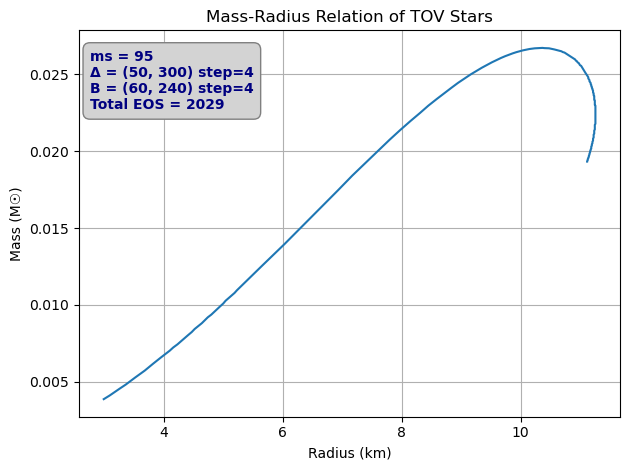

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import fnmatch

# List of folders to search
folders = ['TOV_results_Qark_Stars_tidal']
pattern = '*.csv'

# Loop through each folder and collect matching CSV files
for folder in folders:
    if not os.path.exists(folder):
        continue  # Skip missing folders

    files = [f for f in os.listdir(folder) if fnmatch.fnmatch(f, pattern)]

    for file in files[:1]:
        filepath = os.path.join(folder, file)
        
        # Load CSV data, skipping header
        data = np.genfromtxt(filepath, delimiter=',', skip_header=1)

        if data.ndim == 1 or data.shape[1] < 2:
            continue  # Skip malformed or incomplete files

        # Plot Mass vs Radius
        plt.plot(data[:, 1], data[:, 3], label=f"{folder}/{file.split('.')[0]}")

# Final plot formatting
plt.ylabel("Mass (M☉)")
plt.xlabel("Radius (km)")
plt.title("Mass-Radius Relation of TOV Stars")
plt.grid(True)
plt.text(
    0.02, 0.95,
    'ms = 95\nΔ = (50, 300) step=4\nB = (60, 240) step=4\nTotal EOS = 2029',
    transform=plt.gca().transAxes,
    fontsize=10,
    fontweight='bold',
    color='navy',
    ha='left',  # horizontal alignment
    va='top',   # vertical alignment
    bbox=dict(facecolor='lightgray', edgecolor='gray', boxstyle='round,pad=0.5')
)

plt.tight_layout()
plt.show()


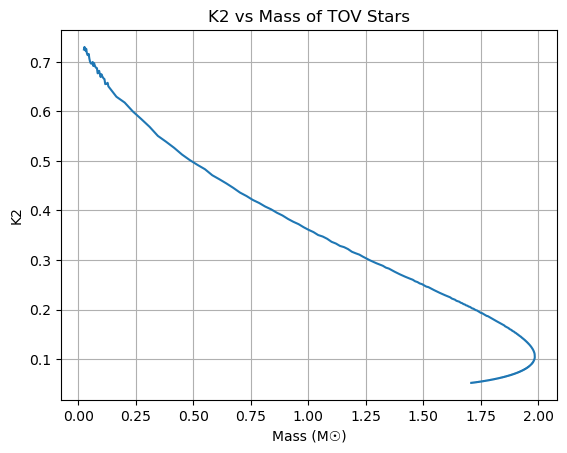

In [ ]:
# Plot K2 vs Mass 
import os
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
# List of folders to search
folders = ['TOV_results_Qark_Stars_tidal']
pattern = '*.csv'
# Loop through each folder and collect matching CSV files
for folder in folders:
    if not os.path.exists(folder):
        continue  # Skip missing folders

    files = [f for f in os.listdir(folder) if fnmatch.fnmatch(f, pattern)]

    for file in files[:1]:
        filepath = os.path.join(folder, file)
        
        # Load CSV data, skipping header
        data = np.genfromtxt(filepath, delimiter=',', skip_header=1)
        # Compactness check
        
        if data.ndim == 1 or data.shape[1] < 2:
            continue  # Skip malformed or incomplete files

        # Plot K2 vs Mass
        plt.plot(data[:, 0], data[:, 3], label=f"{folder}/{file.split('.')[0]}")
# Final plot formatting
plt.ylabel("K2")
plt.xlabel("Mass (M☉)")
plt.title("K2 vs Mass of TOV Stars")
plt.grid(True)


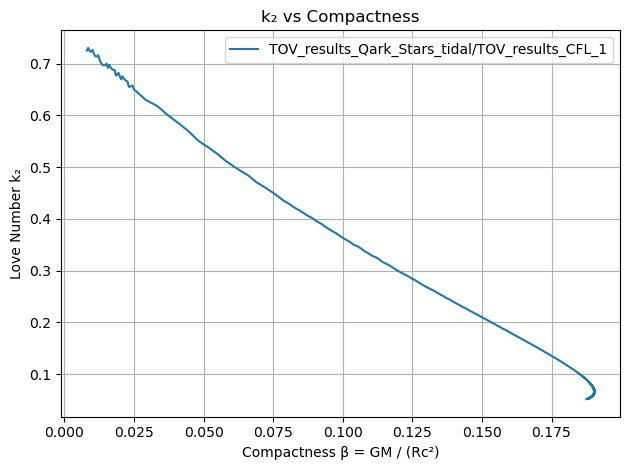

In [15]:
import os
import matplotlib.pyplot as plt
import numpy as np
import fnmatch

# Physical constants
G = 6.67430e-11       # m³ kg⁻¹ s⁻²
c = 2.998e8           # m/s
M_sun = 1.98847e30    # kg

# Folder containing results
folders = ['TOV_results_Qark_Stars_tidal']
pattern = '*.csv'

for folder in folders:
    if not os.path.exists(folder):
        continue

    files = [f for f in os.listdir(folder) if fnmatch.fnmatch(f, pattern)]

    for file in files[:1]:  # Use all or just one file depending on your case
        filepath = os.path.join(folder, file)
        data = np.genfromtxt(filepath, delimiter=',', skip_header=1)

        if data.ndim == 1 or data.shape[1] < 4:
            continue

        mass_solar = data[:, 0]       # Mass in M☉
        radius_km = data[:, 1]        # Radius in km
        k2 = data[:, 3]               # Love number k2


        # Compute compactness β = GM / (R c²)
        beta = mass_solar / radius_km

        # Plot K2 vs Compactness
        plt.plot(beta, k2,  label=f"{folder}/{file.split('.')[0]}")

# Final plot formatting
plt.xlabel("Compactness β = GM / (Rc²)")
plt.ylabel("Love Number k₂")
plt.title("k₂ vs Compactness")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


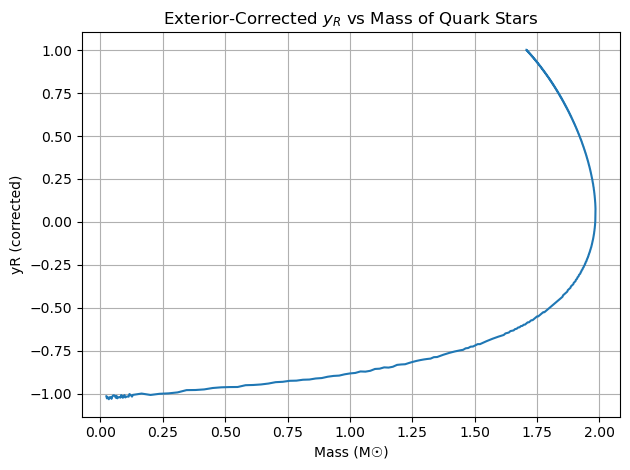

In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np
import fnmatch

folders = ['TOV_results_Qark_Stars_tidal']
pattern = '*.csv'

for folder in folders:
    if not os.path.exists(folder):
        continue

    files = [f for f in os.listdir(folder) if fnmatch.fnmatch(f, pattern)]

    for file in files[:1]:
        filepath = os.path.join(folder, file)
        data = np.genfromtxt(filepath, delimiter=',', skip_header=1)

        if data.ndim == 1 or data.shape[1] < 4:
            continue

        M = data[:, 0]
        yR_ext = data[:, 5]

        valid = np.isfinite(M) & np.isfinite(yR_ext)

        if np.any(valid):
            plt.plot(M[valid], yR_ext[valid], label=file.split('.')[0])

plt.xlabel("Mass (M☉)")
plt.ylabel("yR (corrected)")
plt.title("Exterior-Corrected $y_R$ vs Mass of Quark Stars")
plt.grid(True)
# plt.legend(fontsize=6)
plt.tight_layout()
plt.show()



In [13]:
import os
import csv
import numpy as np
from scipy.integrate import solve_ivp
import multiprocessing
from functools import partial

hbar_c = 197.326
c = 2.998e8
class QEOS:
    def __init__(self, ms, delta, B):
        self.ms = ms
        self.delta = delta
        self.B = B

    def alpha(self):
        return -self.ms**2 / 6 + 2 * self.delta**2 / 3

    def energy_density(self, P):
        a = self.alpha()
        m = np.sqrt(-3 * a + np.sqrt(4 / 3 * np.pi**2 * (self.B + P) * hbar_c**3 + 9 * a**2))
        epsilon = 3 * P + 4 * self.B - 9 * a * m**2 / (np.pi**2 * hbar_c**3)
        return epsilon

def stability_point(ms, mn, delta):
    conversion_factor = hbar_c**3
    return (-ms**2 * mn**2 / (12 * np.pi**2) + delta**2 * mn**2 / (3 * np.pi**2) + mn**4 / (108 * np.pi**2)) / conversion_factor
    
# delta_values = list(range(50, 301, 4)) 
# ms = 95
# B_values = list(range(60, 240, 4)) 
delta_values = [50]
ms = 95 
B_values = [60]
mn = 939  
eos_models = []
model_index = 1
output_folder = "TOV_results_Qark_Stars_tidal"
os.makedirs(output_folder, exist_ok=True)

for b in B_values:
    for d in delta_values:
        if b < stability_point(ms, mn, d):  
            model_name = f"CFL_{model_index}"
            eos_model = QEOS(ms, d, b)
            initial_pressures = np.concatenate((np.arange(1.5, 5, 0.1), np.arange(5, 1501, 1)), axis=None)
            eos_models.append((model_name, eos_model, initial_pressures, output_folder))
            model_index += 1

In [17]:
print(4 * eos_models[0][1].B, eos_models[0][1].energy_density(0))
# Test the first model

240 238.50721828770764


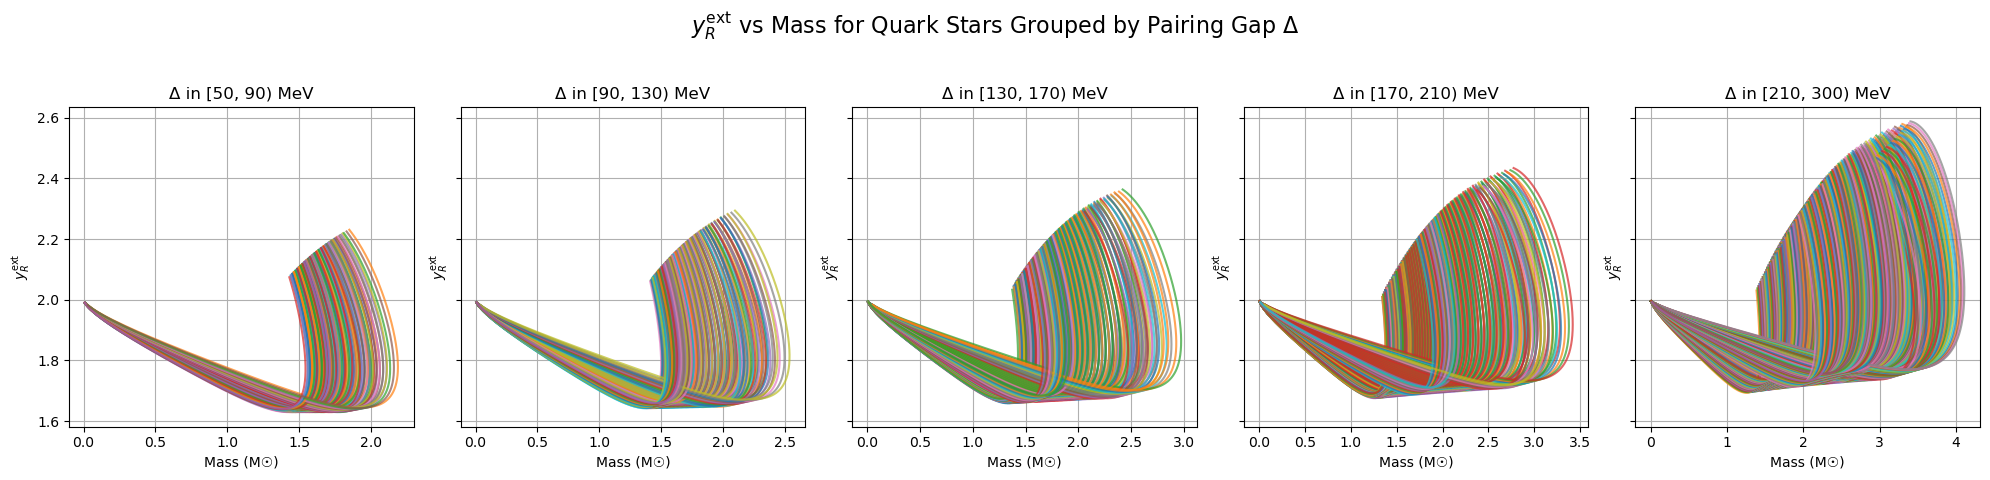

In [37]:
import os
import matplotlib.pyplot as plt
import numpy as np
import fnmatch

# === Reconstruct the delta/B mapping exactly as in your EOS generation ===
delta_values = list(range(50, 301, 4))  # Same as in run_parallel_processing
B_values = list(range(60, 240, 4))
ms = 95
mn = 939
model_map = {}  # index -> (delta, B)

hbar_c = 197.326
def stability_point(ms, mn, delta):
    conv = hbar_c ** 3
    return (-ms**2 * mn**2 / (12 * np.pi**2) + delta**2 * mn**2 / (3 * np.pi**2) + mn**4 / (108 * np.pi**2)) / conv

model_idx = 1
for b in B_values:
    for d in delta_values:
        if b < stability_point(ms, mn, d):
            model_map[f"TOV_results_CFL_{model_idx}"] = (d, b)
            model_idx += 1

# === Define delta bins for subplot categories ===
delta_bins = [(50, 90), (90, 130), (130, 170), (170, 210), (210, 300)]
n_bins = len(delta_bins)

# === Start plotting ===
folders = ['TOV_results_Qark_Stars_tidal']
pattern = '*.csv'
fig, axes = plt.subplots(1, n_bins, figsize=(20, 5), sharey=True)

for folder in folders:
    if not os.path.exists(folder):
        continue

    files = [f for f in os.listdir(folder) if fnmatch.fnmatch(f, pattern)]
    for file in files:
        model_name = file.split('.')[0]
        if model_name not in model_map:
            continue

        delta, B = model_map[model_name]
        filepath = os.path.join(folder, file)
        data = np.genfromtxt(filepath, delimiter=',', skip_header=1)

        if data.ndim == 1 or data.shape[1] < 5:
            continue

        M = data[:, 0]
        R = data[:, 1]
        yR = data[:, 4]

        valid = np.isfinite(M) & np.isfinite(R) & np.isfinite(yR) & (R > 0)
        beta = 1.474 * M[valid] / R[valid]

        # Find which subplot/bin to assign to
        for i, (dmin, dmax) in enumerate(delta_bins):
            if dmin <= delta < dmax:
                axes[i].plot(M[valid], yR[valid], label=f"B={B}", alpha=0.7)
                break

# === Label and format subplots ===
for i, (dmin, dmax) in enumerate(delta_bins):
    axes[i].set_title(f"Δ in [{dmin}, {dmax}) MeV")
    axes[i].set_xlabel("Mass (M☉)")
    axes[i].set_ylabel(r"$y_R^{\mathrm{ext}}$")
    axes[i].grid(True)

plt.suptitle(r"$y_R^{\mathrm{ext}}$ vs Mass for Quark Stars Grouped by Pairing Gap Δ", fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Uncomment for legend in each plot
# for ax in axes: ax.legend(fontsize=6)
plt.show()


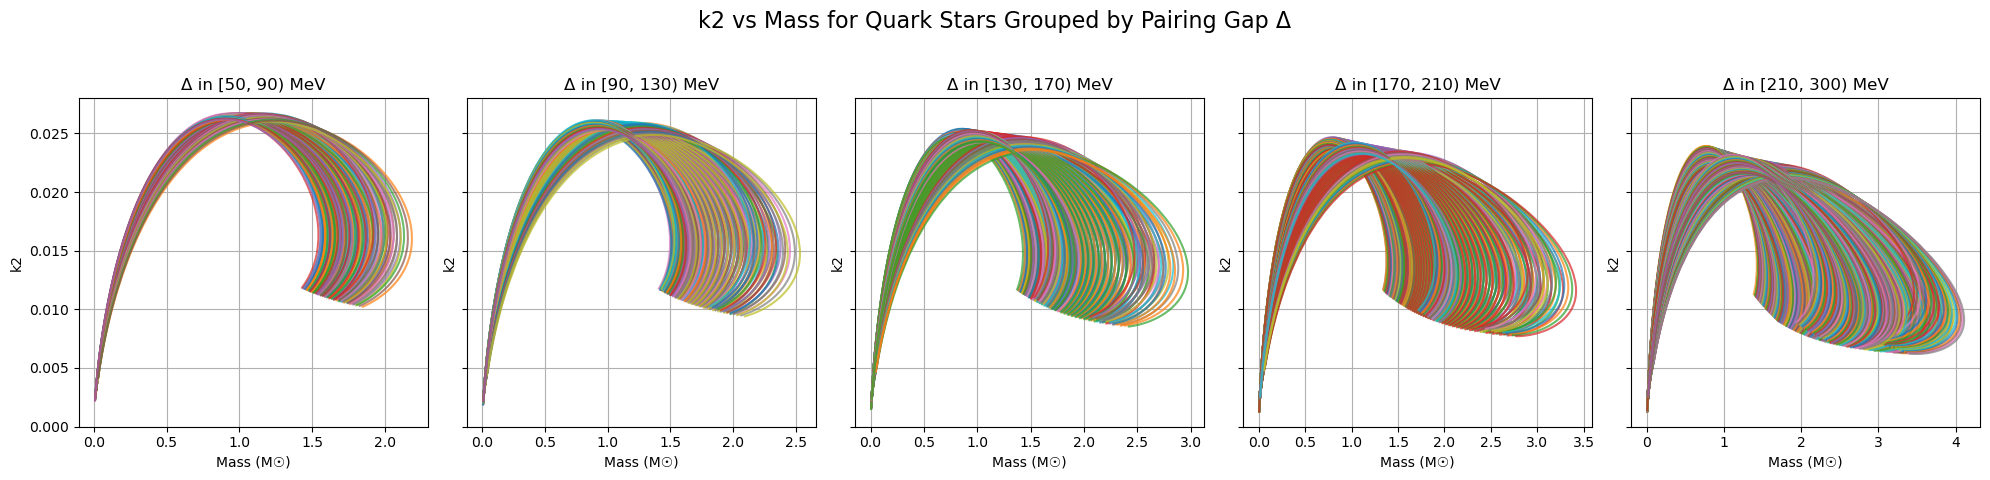

In [38]:
import os
import matplotlib.pyplot as plt
import numpy as np
import fnmatch

# === Reconstruct the delta/B mapping exactly as in your EOS generation ===
delta_values = list(range(50, 301, 4))  # Same as in run_parallel_processing
B_values = list(range(60, 240, 4))
ms = 95
mn = 939
model_map = {}  # index -> (delta, B)

hbar_c = 197.326
def stability_point(ms, mn, delta):
    conv = hbar_c ** 3
    return (-ms**2 * mn**2 / (12 * np.pi**2) + delta**2 * mn**2 / (3 * np.pi**2) + mn**4 / (108 * np.pi**2)) / conv

model_idx = 1
for b in B_values:
    for d in delta_values:
        if b < stability_point(ms, mn, d):
            model_map[f"TOV_results_CFL_{model_idx}"] = (d, b)
            model_idx += 1

# === Define delta bins for subplot categories ===
delta_bins = [(50, 90), (90, 130), (130, 170), (170, 210), (210, 300)]
n_bins = len(delta_bins)

# === Start plotting ===
folders = ['TOV_results_Qark_Stars_tidal']
pattern = '*.csv'
fig, axes = plt.subplots(1, n_bins, figsize=(20, 5), sharey=True)

for folder in folders:
    if not os.path.exists(folder):
        continue

    files = [f for f in os.listdir(folder) if fnmatch.fnmatch(f, pattern)]
    for file in files:
        model_name = file.split('.')[0]
        if model_name not in model_map:
            continue

        delta, B = model_map[model_name]
        filepath = os.path.join(folder, file)
        data = np.genfromtxt(filepath, delimiter=',', skip_header=1)

        if data.ndim == 1 or data.shape[1] < 5:
            continue

        M = data[:, 0]
        R = data[:, 1]
        k2 = data[:, 3]

        valid = np.isfinite(M) & np.isfinite(R) & np.isfinite(k2) & (R > 0)
        beta = 1.474 * M[valid] / R[valid]

        # Find which subplot/bin to assign to
        for i, (dmin, dmax) in enumerate(delta_bins):
            if dmin <= delta < dmax:
                axes[i].plot(M[valid], k2[valid], label=f"B={B}", alpha=0.7)
                break

# === Label and format subplots ===
for i, (dmin, dmax) in enumerate(delta_bins):
    axes[i].set_title(rf"Δ in [{dmin}, {dmax}) MeV")
    axes[i].set_xlabel("Mass (M☉)")
    axes[i].set_ylabel("k2")
    axes[i].grid(True)

plt.suptitle(r"k2 vs Mass for Quark Stars Grouped by Pairing Gap Δ", fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Uncomment for legend in each plot
# for ax in axes: ax.legend(fontsize=6)
plt.show()
